# Apply K-means, Agglomerative Clustering and DBSCAN

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# 1)  Splitting data into Train and cross validation(or test): Stratified Sampling 

In [2]:
project_data = pd.read_csv("train_data.csv", nrows = 5000)
resource_data = pd.read_csv("resources.csv", nrows = 5000)

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (5000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
# Let's check for any "null" or "missing" values
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
Unnamed: 0                                      5000 non-null int64
id                                              5000 non-null object
teacher_id                                      5000 non-null object
teacher_prefix                                  5000 non-null object
school_state                                    5000 non-null object
project_submitted_datetime                      5000 non-null object
project_grade_category                          5000 non-null object
project_subject_categories                      5000 non-null object
project_subject_subcategories                   5000 non-null object
project_title                                   5000 non-null object
project_essay_1                                 5000 non-null object
project_essay_2                                 5000 non-null object
project_essay_3                                 157 non-null objec

In [5]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [6]:
# Let's select only the selected features or columns, dropping "project_resource_summary" as it is optional
# 
project_data.drop(['id','teacher_id','project_submitted_datetime','project_resource_summary'],axis=1, inplace=True)
project_data.columns

Index(['Unnamed: 0', 'teacher_prefix', 'school_state',
       'project_grade_category', 'project_subject_categories',
       'project_subject_subcategories', 'project_title', 'project_essay_1',
       'project_essay_2', 'project_essay_3', 'project_essay_4',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')

In [7]:
# Data seems to be highly imbalanced since the ratio of "class 1" to "class 0" is nearly 5.5
project_data['project_is_approved'].value_counts()

1    4237
0     763
Name: project_is_approved, dtype: int64

In [8]:
number_of_approved = project_data['project_is_approved'][project_data['project_is_approved'] == 1].count()
number_of_not_approved = project_data['project_is_approved'][project_data['project_is_approved'] == 0].count()

print("Ratio of Project approved to Not approved is:", number_of_approved/number_of_not_approved)

Ratio of Project approved to Not approved is: 5.553079947575361


Let's first merge all the project_essays into single columns 

In [9]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [10]:
project_data.head(2)

Unnamed: 0 teacher_prefix school_state project_grade_category  \
0      160221           Mrs.           IN          Grades PreK-2   
1      140945            Mr.           FL             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4  teacher_number_of_previously_posted_projects  \
0             NaN                                             0   
1             NaN                                             7   

   project_is_approved  price  quantity  \
0                    0    NaN       NaN   
1                    1    NaN       NaN   

                                               essay  
0  My students are English learners that are work...  
1  Our students arrive to our school eager to lea...

In [11]:
# Let's drop the project essay columns from the dadaset now, as we have captured the essay text data into single "essay" column
project_data.drop(['project_essay_1','project_essay_2','project_essay_3','project_essay_4'],axis=1, inplace=True)

In [12]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)
X.head(1)

Unnamed: 0 teacher_prefix school_state project_grade_category  \
0      160221           Mrs.           IN          Grades PreK-2   

  project_subject_categories project_subject_subcategories  \
0        Literacy & Language                 ESL, Literacy   

                                      project_title  \
0  Educational Support for English Learners at Home   

   teacher_number_of_previously_posted_projects  price  quantity  \
0                                             0    NaN       NaN   

                                               essay  
0  My students are English learners that are work...

In [13]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

# 2) Make Data Model Ready: encoding numerical, categorical features

In [14]:
def cleaning_text_data(list_text_feature,df,old_col_name,new_col_name):
    
    # remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
    # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
    # https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
    # https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
    feature_list = []
    for i in list_text_feature:
        temp = ""
        # consider we have text like this "Math & Science, Warmth, Care & Hunger"
        for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
            if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
                j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
            j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
            temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
            temp = temp.replace('&','_') # we are replacing the & value into 
        feature_list.append(temp.strip())

    df[new_col_name] = feature_list
    df.drop([old_col_name], axis=1, inplace=True)

    from collections import Counter
    my_counter = Counter()
    for word in df[new_col_name].values:
        my_counter.update(word.split())

    feature_dict = dict(my_counter)
    sorted_feature_dict = dict(sorted(feature_dict.items(), key=lambda kv: kv[1]))
    return sorted_feature_dict


In [15]:
def clean_project_grade(list_text_feature,df,old_col_name,new_col_name):
    
    # remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
    # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
    # https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
    # https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
    feature_list = []
    for i in list_text_feature:
        temp = i.split(' ')
        last_dig = temp[-1].split('-')
        fin = [temp[0]]
        fin.extend(last_dig)
        feature = '_'.join(fin)
        feature_list.append(feature.strip())

    df[new_col_name] = feature_list
    df.drop([old_col_name], axis=1, inplace=True)

    from collections import Counter
    my_counter = Counter()
    for word in df[new_col_name].values:
        my_counter.update(word.split())

    feature_dict = dict(my_counter)
    sorted_feature_dict = dict(sorted(feature_dict.items(), key=lambda kv: kv[1]))
    return sorted_feature_dict


## 2.1) Text Preprocessing: project_subject_categories

In [16]:
x_train_sorted_category_dict = cleaning_text_data(X_train['project_subject_categories'],X_train,'project_subject_categories','clean_categories')
x_test_sorted_category_dict = cleaning_text_data(X_test['project_subject_categories'],X_test,'project_subject_categories','clean_categories')

## 2.2) Text Preprocessing : project_subject_subcategories

In [17]:
x_train_sorted_subcategories = cleaning_text_data(X_train['project_subject_subcategories'],X_train,'project_subject_subcategories','clean_subcategories')
x_test_sorted_subcategories = cleaning_text_data(X_test['project_subject_subcategories'],X_test,'project_subject_subcategories','clean_subcategories')

## 2.3) Text Preprocessing: project_grade_category

In [18]:
x_train_sorted_grade = clean_project_grade(X_train['project_grade_category'],X_train,'project_grade_category','clean_grade')
x_test_sorted_grade = clean_project_grade(X_test['project_grade_category'],X_test,'project_grade_category','clean_grade')

## 2.4) Text Preprocessing (stowords): project_essay, project_title

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
def process_text(df,col_name):
    preprocessed_feature = []
    # tqdm is for printing the status bar
    for sentance in tqdm(df[col_name].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_feature.append(sent.lower().strip())
    return preprocessed_feature

In [22]:
x_train_essay_preprocessed = process_text(X_train,'essay')
x_test_essay_preprocessed = process_text(X_test,'essay')

100%|█████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:01<00:00, 958.74it/s]


In [23]:
x_train_title_preprocessed = process_text(X_train,'project_title')
x_test_title_preprocessed = process_text(X_test,'project_title')

100%|███████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 17370.86it/s]


## 2.5) Vectorizing Categorical Data 

### project_subject_categories (clean_categories)

In [24]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
def cat_vectorizer(X_train,df,col_name):
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train[col_name].values)
    feature_one_hot = vectorizer.transform(df[col_name].values)
    print(vectorizer.get_feature_names())
    return feature_one_hot, vectorizer.get_feature_names()

In [25]:
x_train_cat_one_hot, x_train_cat_feat_list = cat_vectorizer(X_train,X_train,'clean_categories')
x_test_cat_one_hot, x_test_cat_feat_list = cat_vectorizer(X_train,X_test,'clean_categories')

['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [26]:
# shape after categorical one hot encoding
print(x_train_cat_one_hot.shape)
print(x_test_cat_one_hot.shape)

(3350, 9)
(1650, 9)


### project_subject_subcategory (clean_subcategory)

In [27]:
x_train_subcat_one_hot, x_train_subcat_feat_list = cat_vectorizer(X_train,X_train,'clean_subcategories')
x_test_subcat_one_hot, x_test_subcat_feat_list = cat_vectorizer(X_train,X_test,'clean_subcategories')

['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneed

In [28]:
# shape after categorical one hot encoding
print(x_train_subcat_one_hot.shape)
print(x_test_subcat_one_hot.shape)

(3350, 30)
(1650, 30)


### school_state 

In [29]:
# we use count vectorizer to convert the values into one hot encoding
# CountVectorizer for "school_state"
x_train_state_one_hot, x_train_state_feat_list = cat_vectorizer(X_train,X_train,'school_state')
x_test_state_one_hot, x_test_state_feat_list = cat_vectorizer(X_train,X_test,'school_state')

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [30]:
# shape after categorical one hot encoding
print(x_train_state_one_hot.shape)
print(x_test_state_one_hot.shape)

(3350, 51)
(1650, 51)


### teacher_prefix

In [31]:
# we use count vectorizer to convert the values into one hot encoding
# CountVectorizer for teacher_prefix
x_train_teacher_prefix_one_hot,x_train_teacher_prefix_feat_list = cat_vectorizer(X_train,X_train,'teacher_prefix')
x_test_teacher_prefix_one_hot,x_test_teacher_prefix_feat_list = cat_vectorizer(X_train,X_test,'teacher_prefix')

['mr', 'mrs', 'ms', 'teacher']
['mr', 'mrs', 'ms', 'teacher']


In [32]:
# shape after categorical one hot encoding
print(x_train_teacher_prefix_one_hot.shape)
print(x_test_teacher_prefix_one_hot.shape)

(3350, 4)
(1650, 4)


### project_grade_category 

In [33]:
# using count vectorizer for one-hot encoding of project_grade_category
x_train_grade_one_hot, x_train_grade_feat_list = cat_vectorizer(X_train,X_train,'clean_grade')
x_test_grade_one_hot, x_test_grade_feat_list = cat_vectorizer(X_train,X_test,'clean_grade')

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [34]:
# shape after categorical one hot encoding
print(x_train_grade_one_hot.shape)
print(x_test_grade_one_hot.shape)

(3350, 4)
(1650, 4)


## 2.6) Vectorizing Text Data

### 2.6.1) Bag of Words (essay)

In [35]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
def bow_vectorizer(X_train,col_name,df):
    vectorizer = CountVectorizer(min_df=10, max_features=5000)
    vectorizer.fit(X_train[col_name].values)
    df_bow = vectorizer.transform(df[col_name].values)
    return df_bow, vectorizer.get_feature_names()
    

In [36]:
x_train_essay_bow, x_train_essay_feat = bow_vectorizer(X_train,'essay',X_train)
x_test_essay_bow,  x_test_essay_feat  = bow_vectorizer(X_train,'essay',X_test)


In [37]:
print(x_train_essay_bow.shape)
print(x_test_essay_bow.shape)

(3350, 3656)
(1650, 3656)


### 2.6.2) Bag of Words (title)

In [38]:
def bow_vectorizer_title(X_train,col_name,df):
    vectorizer = CountVectorizer(max_features = 5000)
    vectorizer.fit(X_train[col_name].values)
    df_bow = vectorizer.transform(df[col_name].values)
    return df_bow, vectorizer.get_feature_names()

In [39]:
x_train_title_bow, x_train_title_feat = bow_vectorizer_title(X_train,'project_title',X_train)
x_test_title_bow,  x_test_title_feat  = bow_vectorizer_title(X_train,'project_title',X_test)

In [40]:
print(x_train_title_bow.shape)
print(x_test_title_bow.shape)

(3350, 3120)
(1650, 3120)


### 2.6.3) TFIDF (essay) 

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
# We are considering only the words which appeared in at least 10 documents(rows or projects).
def tfidf_vectorizer(X_train,col_name,df):
    vectorizer = TfidfVectorizer(min_df=10, max_features = 5000)
    vectorizer.fit(X_train[col_name].values)
    df_tfidf = vectorizer.transform(df[col_name].values)
    return df_tfidf, vectorizer.get_feature_names()

In [42]:
# Lets vectorize essay
x_train_essay_tfidf, x_train_essay_tfidf_feat = tfidf_vectorizer(X_train,'essay',X_train)
x_test_essay_tfidf, x_test_essay_tfidf_feat = tfidf_vectorizer(X_train,'essay',X_test)

In [43]:
print(x_train_essay_tfidf.shape)
print(x_test_essay_tfidf.shape)

(3350, 3656)
(1650, 3656)


### 2.6.4) TFIDF (title)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_vectorizer_title(X_train,col_name,df):
    vectorizer = TfidfVectorizer(max_features = 5000)
    vectorizer.fit(X_train[col_name].values)
    df_tfidf = vectorizer.transform(df[col_name].values)
    return df_tfidf, vectorizer.get_feature_names()

In [45]:
# Lets vectorize essay
x_train_title_tfidf, x_train_title_tfidf_feat = tfidf_vectorizer_title(X_train,'project_title',X_train)
x_test_title_tfidf, x_test_title_tfidf_feat = tfidf_vectorizer_title(X_train,'project_title',X_test)


In [46]:
print(x_train_title_tfidf.shape)
print(x_test_title_tfidf.shape)

(3350, 3120)
(1650, 3120)


### 2.6.5) Using Pretrained Models: Avg W2V

In [47]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [48]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [49]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_essay(df,col_name):
    preprocessed_essays = []
    # tqdm is for printing the status bar
    for sentance in tqdm(df[col_name].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_essays.append(sent.lower().strip())
    return preprocessed_essays

In [50]:
# average Word2Vec
# compute average word2vec for each review.
def compute_avg_W2V(preprocessed_feature):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_feature): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return avg_w2v_vectors


In [51]:
x_train_preprocessed_essay = preprocess_essay(X_train,'essay')
x_test_preprocessed_essay = preprocess_essay(X_test,'essay')

100%|████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:01<00:00, 1062.47it/s]


In [52]:
x_train_preprocessed_title = preprocess_essay(X_train,'project_title')
x_test_preprocessed_title = preprocess_essay(X_test,'project_title')

100%|███████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 20125.69it/s]


In [53]:
x_train_avg_w2v_essay = compute_avg_W2V(x_train_preprocessed_essay)
x_test_avg_w2v_essay = compute_avg_W2V(x_test_preprocessed_essay)

100%|████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:01<00:00, 1384.24it/s]


In [54]:
x_train_avg_w2v_title = compute_avg_W2V(x_train_preprocessed_title)
x_test_avg_w2v_title = compute_avg_W2V(x_test_preprocessed_title)

100%|███████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 27504.29it/s]


### 2.6.6) Using Pretrained Models: TFIDF Weighted W2V

In [55]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
def get_tfidf_dict(preprocessed_feature):
    tfidf_model = TfidfVectorizer(max_features = 5000)
    tfidf_model.fit(preprocessed_feature)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    return dictionary, tfidf_words

In [56]:
# average Word2Vec
# compute average word2vec for each review.
def compute_tfidf_w2v_vectors(preprocessed_feature):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    dictionary, tfidf_words = get_tfidf_dict(preprocessed_feature)
    for sentence in tqdm(preprocessed_feature): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

In [57]:
x_train_weighted_w2v_essay = compute_tfidf_w2v_vectors(x_train_essay_preprocessed)
x_test_weighted_w2v_essay= compute_tfidf_w2v_vectors(x_test_essay_preprocessed)

100%|█████████████████████████████████████████████████████████████████████████████| 1650/1650 [00:06<00:00, 250.80it/s]


In [58]:
x_train_weighted_w2v_title = compute_tfidf_w2v_vectors(x_train_title_preprocessed)
x_test_weighted_w2v_title= compute_tfidf_w2v_vectors(x_test_title_preprocessed)

100%|███████████████████████████████████████████████████████████████████████████| 1650/1650 [00:00<00:00, 17187.93it/s]


### 2.6.7) Vectorizing Numerical Features

We have 2 numerical features left, "price" and "teacher_number_of_previously_posted_projects". Let's check for the "missing" or "NaN" values present in those numerical features and use "Mean Replacement" for "price" and "Mode Replacement" for "teacher_number_of_previously_posted_projects". 

In [59]:
print("Total number of \"Missing\" Values present in X_train price:",X_train['price'].isna().sum())
print("Total number of \"Missing\" Values present in X_test price:",X_test['price'].isna().sum())

Total number of "Missing" Values present in X_train price: 3344
Total number of "Missing" Values present in X_test price: 1644


In [60]:
print("Total number of \"Missing\" Values present in X_train previous teacher number:",X_train['teacher_number_of_previously_posted_projects'].isna().sum())
print("Total number of \"Missing\" Values present in X_test previous teacher number:",X_test['teacher_number_of_previously_posted_projects'].isna().sum())

Total number of "Missing" Values present in X_train previous teacher number: 0
Total number of "Missing" Values present in X_test previous teacher number: 0


"teacher_number_of_previously_posted_projects" does not have any "missing" values.

In [61]:
X_train['price'].mean()

254.66000000000005

In [62]:
X_train['price'] = X_train['price'].fillna(254.66)

In [63]:
X_test['price'].mean()

358.23166666666674

In [64]:
X_test['price'] = X_test['price'].fillna(358.2316)

In [65]:
print(X_train['quantity'].mean())
print(X_test['quantity'].mean())

10.333333333333334
22.833333333333332


In [66]:
X_train['quantity'] = X_train['quantity'].fillna(10.3333)
X_test['quantity'] = X_test['quantity'].fillna(22.8333)

In [67]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
def scaler_function(df,col_name):

    scaler = StandardScaler()
    scaler.fit(df[col_name].values.reshape(-1,1)) # finding the mean and standard deviation of this data

    # Now standardize the data with above maen and variance.
    print(f"Mean : {scaler.mean_[0]}, Standard deviation : {np.sqrt(scaler.var_[0])}")
    scaled = scaler.transform(df[col_name].values.reshape(-1, 1))
    return scaled

#### teacher_number_of_previously_posted_projects

In [68]:
x_train_teacher_number = scaler_function(X_train,'teacher_number_of_previously_posted_projects')
x_test_teacher_number = scaler_function(X_test,'teacher_number_of_previously_posted_projects')

Mean : 10.362686567164179, Standard deviation : 25.956693760787644
Mean : 11.556363636363637, Standard deviation : 28.399394553745047


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



#### price

In [69]:
x_train_price = scaler_function(X_train,'price')
x_test_price = scaler_function(X_test,'price')

Mean : 254.65999999999997, Standard deviation : 5.570720781896249
Mean : 358.2316002424242, Standard deviation : 33.09722661349538


In [70]:
x_train_quantity = scaler_function(X_train,'quantity')
x_test_quantity = scaler_function(X_test,'quantity')

Mean : 10.33330005970149, Standard deviation : 0.5467224822876798
Mean : 22.833300121212126, Standard deviation : 1.658556022813853


## 2.8) Merging all the features and building the sets 

In [71]:
# train dataset
print("After Vectorization and One hot encoding train dataset shape becomes:")
print(x_train_cat_one_hot.shape)
print(x_train_subcat_one_hot.shape)
print(x_train_state_one_hot.shape)
print(x_train_teacher_prefix_one_hot.shape)
print(x_train_grade_one_hot.shape)
print(x_train_essay_bow.shape)
print(x_train_title_bow.shape)
print(x_train_essay_tfidf.shape)
print(x_train_title_tfidf.shape)
print(np.asarray(x_train_avg_w2v_essay).shape)
print(np.asarray(x_train_avg_w2v_title).shape)
print(np.asarray(x_train_weighted_w2v_essay).shape) 
print(np.asarray(x_train_weighted_w2v_title).shape)
print(x_train_teacher_number.shape)
print(x_train_price.shape)
print(x_train_quantity.shape)
print("="*50)

# test dataset
print("After Vectorization and One hot encoding test dataset shape becomes:")
print(x_test_cat_one_hot.shape)
print(x_test_subcat_one_hot.shape)
print(x_test_state_one_hot.shape)
print(x_test_teacher_prefix_one_hot.shape)
print(x_test_grade_one_hot.shape)
print(x_test_essay_bow.shape)
print(x_test_title_bow.shape)
print(x_test_essay_tfidf.shape)
print(x_test_title_tfidf.shape)
print(np.asarray(x_test_avg_w2v_essay).shape)
print(np.asarray(x_test_avg_w2v_title).shape)
print(np.asarray(x_test_weighted_w2v_essay).shape)
print(np.asarray(x_test_weighted_w2v_title).shape)
print(x_test_teacher_number.shape)
print(x_test_price.shape)
print(x_test_quantity.shape)
print("="*50)


After Vectorization and One hot encoding train dataset shape becomes:
(3350, 9)
(3350, 30)
(3350, 51)
(3350, 4)
(3350, 4)
(3350, 3656)
(3350, 3120)
(3350, 3656)
(3350, 3120)
(3350, 300)
(3350, 300)
(3350, 300)
(3350, 300)
(3350, 1)
(3350, 1)
(3350, 1)
After Vectorization and One hot encoding test dataset shape becomes:
(1650, 9)
(1650, 30)
(1650, 51)
(1650, 4)
(1650, 4)
(1650, 3656)
(1650, 3120)
(1650, 3656)
(1650, 3120)
(1650, 300)
(1650, 300)
(1650, 300)
(1650, 300)
(1650, 1)
(1650, 1)
(1650, 1)


## Making Set for all in One

In [72]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_set = hstack((x_train_cat_one_hot,x_train_subcat_one_hot,x_train_state_one_hot,x_train_teacher_prefix_one_hot,x_train_grade_one_hot,x_train_teacher_number,\
                        x_train_price,x_train_quantity,x_train_title_bow,x_train_title_tfidf, x_train_avg_w2v_title, x_train_weighted_w2v_title, x_train_essay_bow, x_train_essay_tfidf, x_train_avg_w2v_essay, x_train_weighted_w2v_essay)).tocsr()
X_test_set = hstack((x_test_cat_one_hot,x_test_subcat_one_hot,x_test_state_one_hot,x_test_teacher_prefix_one_hot,x_test_grade_one_hot,x_test_teacher_number,x_test_price,\
                       x_test_quantity,x_test_title_bow,x_test_title_tfidf, x_test_avg_w2v_title, x_test_weighted_w2v_title, x_test_essay_bow, x_test_essay_tfidf, x_test_avg_w2v_essay, x_test_weighted_w2v_essay)).tocsr()

In [73]:
print(X_train_set.shape)
print(X_test_set.shape)

(3350, 14853)
(1650, 14853)


# K-Means

## Find best "K" using Elbow Method

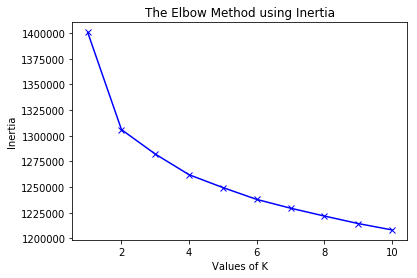

In [76]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import math

K_list = [1,2,3,4,5,6,7,8,9,10]
inertia_ = []
for k in K_list:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_train_set)
    inertia_.append(kmeans.inertia_)
    
plt.plot(K_list, inertia_, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [158]:
# Best "K" from the elbow method is 
Besk_K = 2

In [159]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import math


kmeans = KMeans(n_clusters = Besk_K)
kmeans.fit(X_train_set, y_train)
predict_ = kmeans.predict(X_train_set)


In [160]:
kmeans.labels_

array([1, 1, 0, ..., 0, 0, 0])

In [161]:
predict_

array([1, 1, 0, ..., 0, 0, 0])

Train confusion matrix


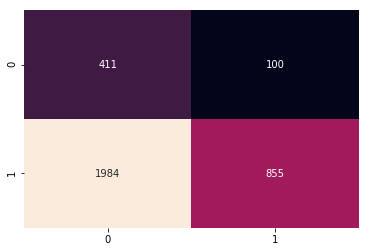

In [164]:
print("Train confusion matrix")
sns.heatmap(confusion_matrix(y_train, predict_),annot = True, fmt = "d", cbar=False)

Test confusion matrix


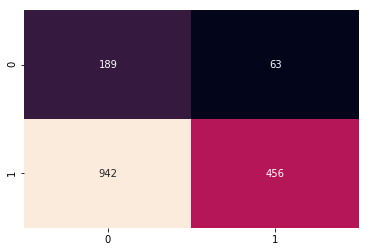

In [165]:
print("Test confusion matrix")
predict_ = kmeans.predict(X_test_set)
sns.heatmap(confusion_matrix(y_test, predict_),annot = True, fmt = "d", cbar=False)

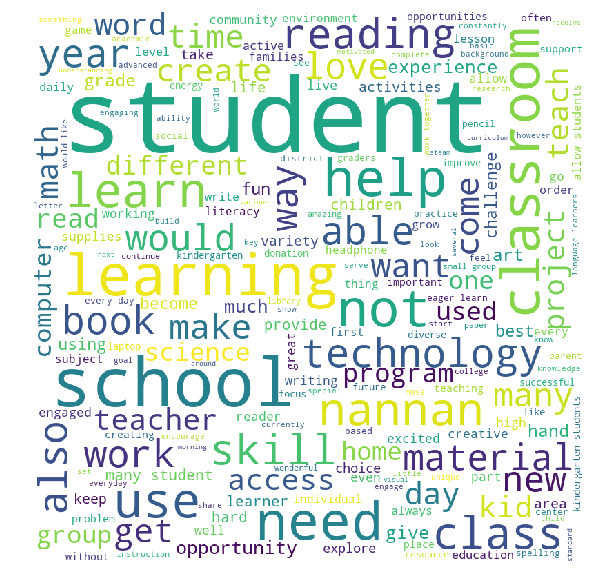

In [166]:
# y_test we have as y_test from train_test_split
# https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud
y_actual = y_test
# y_predicted would be
y_pred = predict_
essay_words = " "
essay_ = []
for i in range(len(y_pred)): 
    if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           essay_.append(x_train_preprocessed_essay[i])
for essay in essay_:
    essay_words += essay + " "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(essay_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()   

# Agglomerative Clustering

In [88]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
from sklearn.cluster import AgglomerativeClustering

ACluster = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean",linkage = "ward")
ACluster.fit_predict(X_train_set.toarray())

print(ACluster.labels_)

[1 1 0 ... 0 0 0]


### Wordcloud on train set

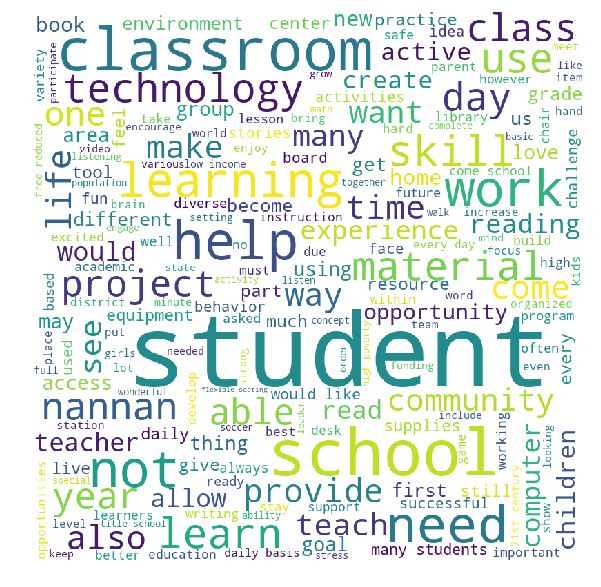

In [170]:
y_actual = y_train
# y_predicted would be
y_pred = ACluster.labels_
essay_words = " "
essay_ = []
for i in range(len(y_pred)): 
    if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           essay_.append(x_train_preprocessed_essay[i])
for essay in essay_:
    essay_words += essay + " "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(essay_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()   

# DBSCAN Clustering

## Finding best "eps" using Elbow Method

In [111]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
min_samples = X_train.shape[1] * 2 
min_samples

22

In [176]:
k = 2
nbrs = NearestNeighbors(n_neighbors = k)
nbrs.fit(X_train_set)
distances, indices = nbrs.kneighbors(X_train_set)

In [177]:
# Let's print the distances and indices
print("min_samples :" + str(min_samples))
print("shape of the distance matrix:" + str(distances.shape) + "\n")
for enum, row in enumerate(distances[:5]):
    print("observations " + str(enum) + " : " + str([round(x ,2) for x in row]) )

min_samples :22
shape of the distance matrix:(3350, 2)

observations 0 : [0.0, 30.76]
observations 1 : [0.0, 30.52]
observations 2 : [0.0, 24.47]
observations 3 : [0.0, 22.51]
observations 4 : [0.0, 20.38]


In [178]:
# the last cell of each row represents the distance of the k'th farthest point
distances[:-1][:5]

array([[ 0.        , 30.7647346 ],
       [ 0.        , 30.52309493],
       [ 0.        , 24.47101833],
       [ 0.        , 22.50739869],
       [ 0.        , 20.37772266]])

In [179]:
distances.shape

(3350, 2)

In [180]:
X_train['knn_farthest_distance'] = distances[:,-1]
X_train.head(5)

Unnamed: 0 teacher_prefix school_state  \
2540       18362            Ms.           MA   
3028       31427            Ms.           NC   
1255       29693           Mrs.           MA   
2577      111852        Teacher           CA   
797        92948           Mrs.           PA   

                                       project_title  \
2540         Think it, Plan it, Create it, Share it!   
3028  Extraordinary Students Need Ordinary Supplies!   
1255               Can You Imagine Living Back Then?   
2577                            \"Bluetooth Boogie\"   
797                        We want to learn English!   

      teacher_number_of_previously_posted_projects   price  quantity  \
2540                                             1  254.66   10.3333   
3028                                             3  254.66   10.3333   
1255                                             0  254.66   10.3333   
2577                                             1  254.66   10.3333   
797                                             19  254.66   10.3333   

                                                  essay  \
2540  This upcoming school year I will have 24 eager...   
3028  How can we close the achievement gap when stud...   
1255  I work in an urban city full of diversity. It ...   
2577  My students are all in special education and t...   
797   My students are special kids! They are coming ...   

                    clean_categories                  clean_subcategories  \
2540                    Math_Science     EnvironmentalScience Mathematics   
3028  Literacy_Language Math_Science       Literature_Writing Mathematics   
1255                  History_Civics  Civics_Government History_Geography   
2577      Health_Sports SpecialNeeds             Gym_Fitness SpecialNeeds   
797                Literacy_Language                         ESL Literacy   

        clean_grade  knn_farthest_distance  cluister  cluster  
2540     Grades_3_5              30.764735        -1       -1  
3028     Grades_3_5              30.523095        -1       -1  
1255     Grades_3_5              24.471018         0        0  
2577  Grades_PreK_2              22.507399         0        0  
797   Grades_PreK_2              20.377723         0        0

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning:

Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



<Figure size 1440x1440 with 0 Axes>

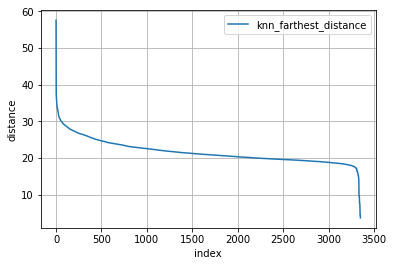

In [181]:
plt.figure(figsize = (20,20))
X_train.sort_values("knn_farthest_distance", ascending = False).reset_index()[['knn_farthest_distance']].plot()
plt.xlabel("index")
plt.ylabel("distance")
plt.grid("True")
plt.show()

In [129]:
# from the elbow graph, eps = 27
eps = 27

In [137]:
km = DBSCAN(eps = 27, min_samples = min_samples)
X_train['cluster'] = km.fit_predict(X_train_set)
X_train['cluster'].value_counts()

 0    3115
-1     235
Name: cluster, dtype: int64

In [183]:
list(set(X_train['cluster'].values))

[0, -1]

In [175]:
len(km.labels_)

3350

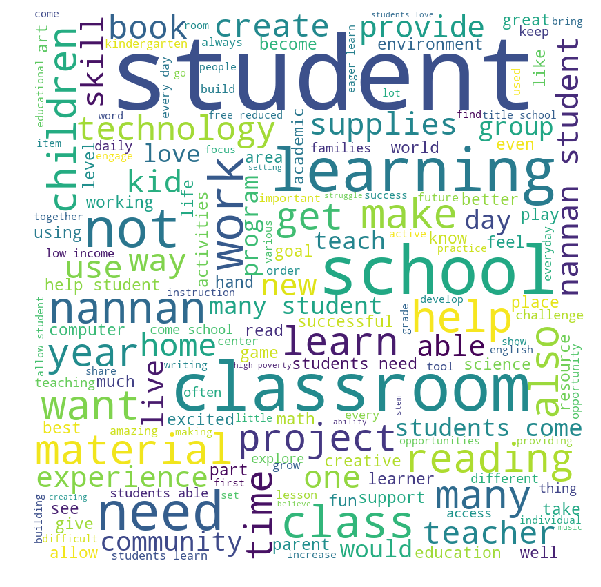

In [188]:
y_actual = y_train
# y_predicted would be
clusters_ = [1 if i == 0 else i for i in X_train['cluster'].values] 

y_pred = clusters_
essay_words = " "
essay_ = []
for i in range(len(y_pred)): 
    if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           essay_.append(x_train_preprocessed_essay[i])
for essay in essay_:
    essay_words += essay + " "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(essay_words) 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()   